#### Mandatory coin-flip example

Every statistics must contain a coin-flipping example. 

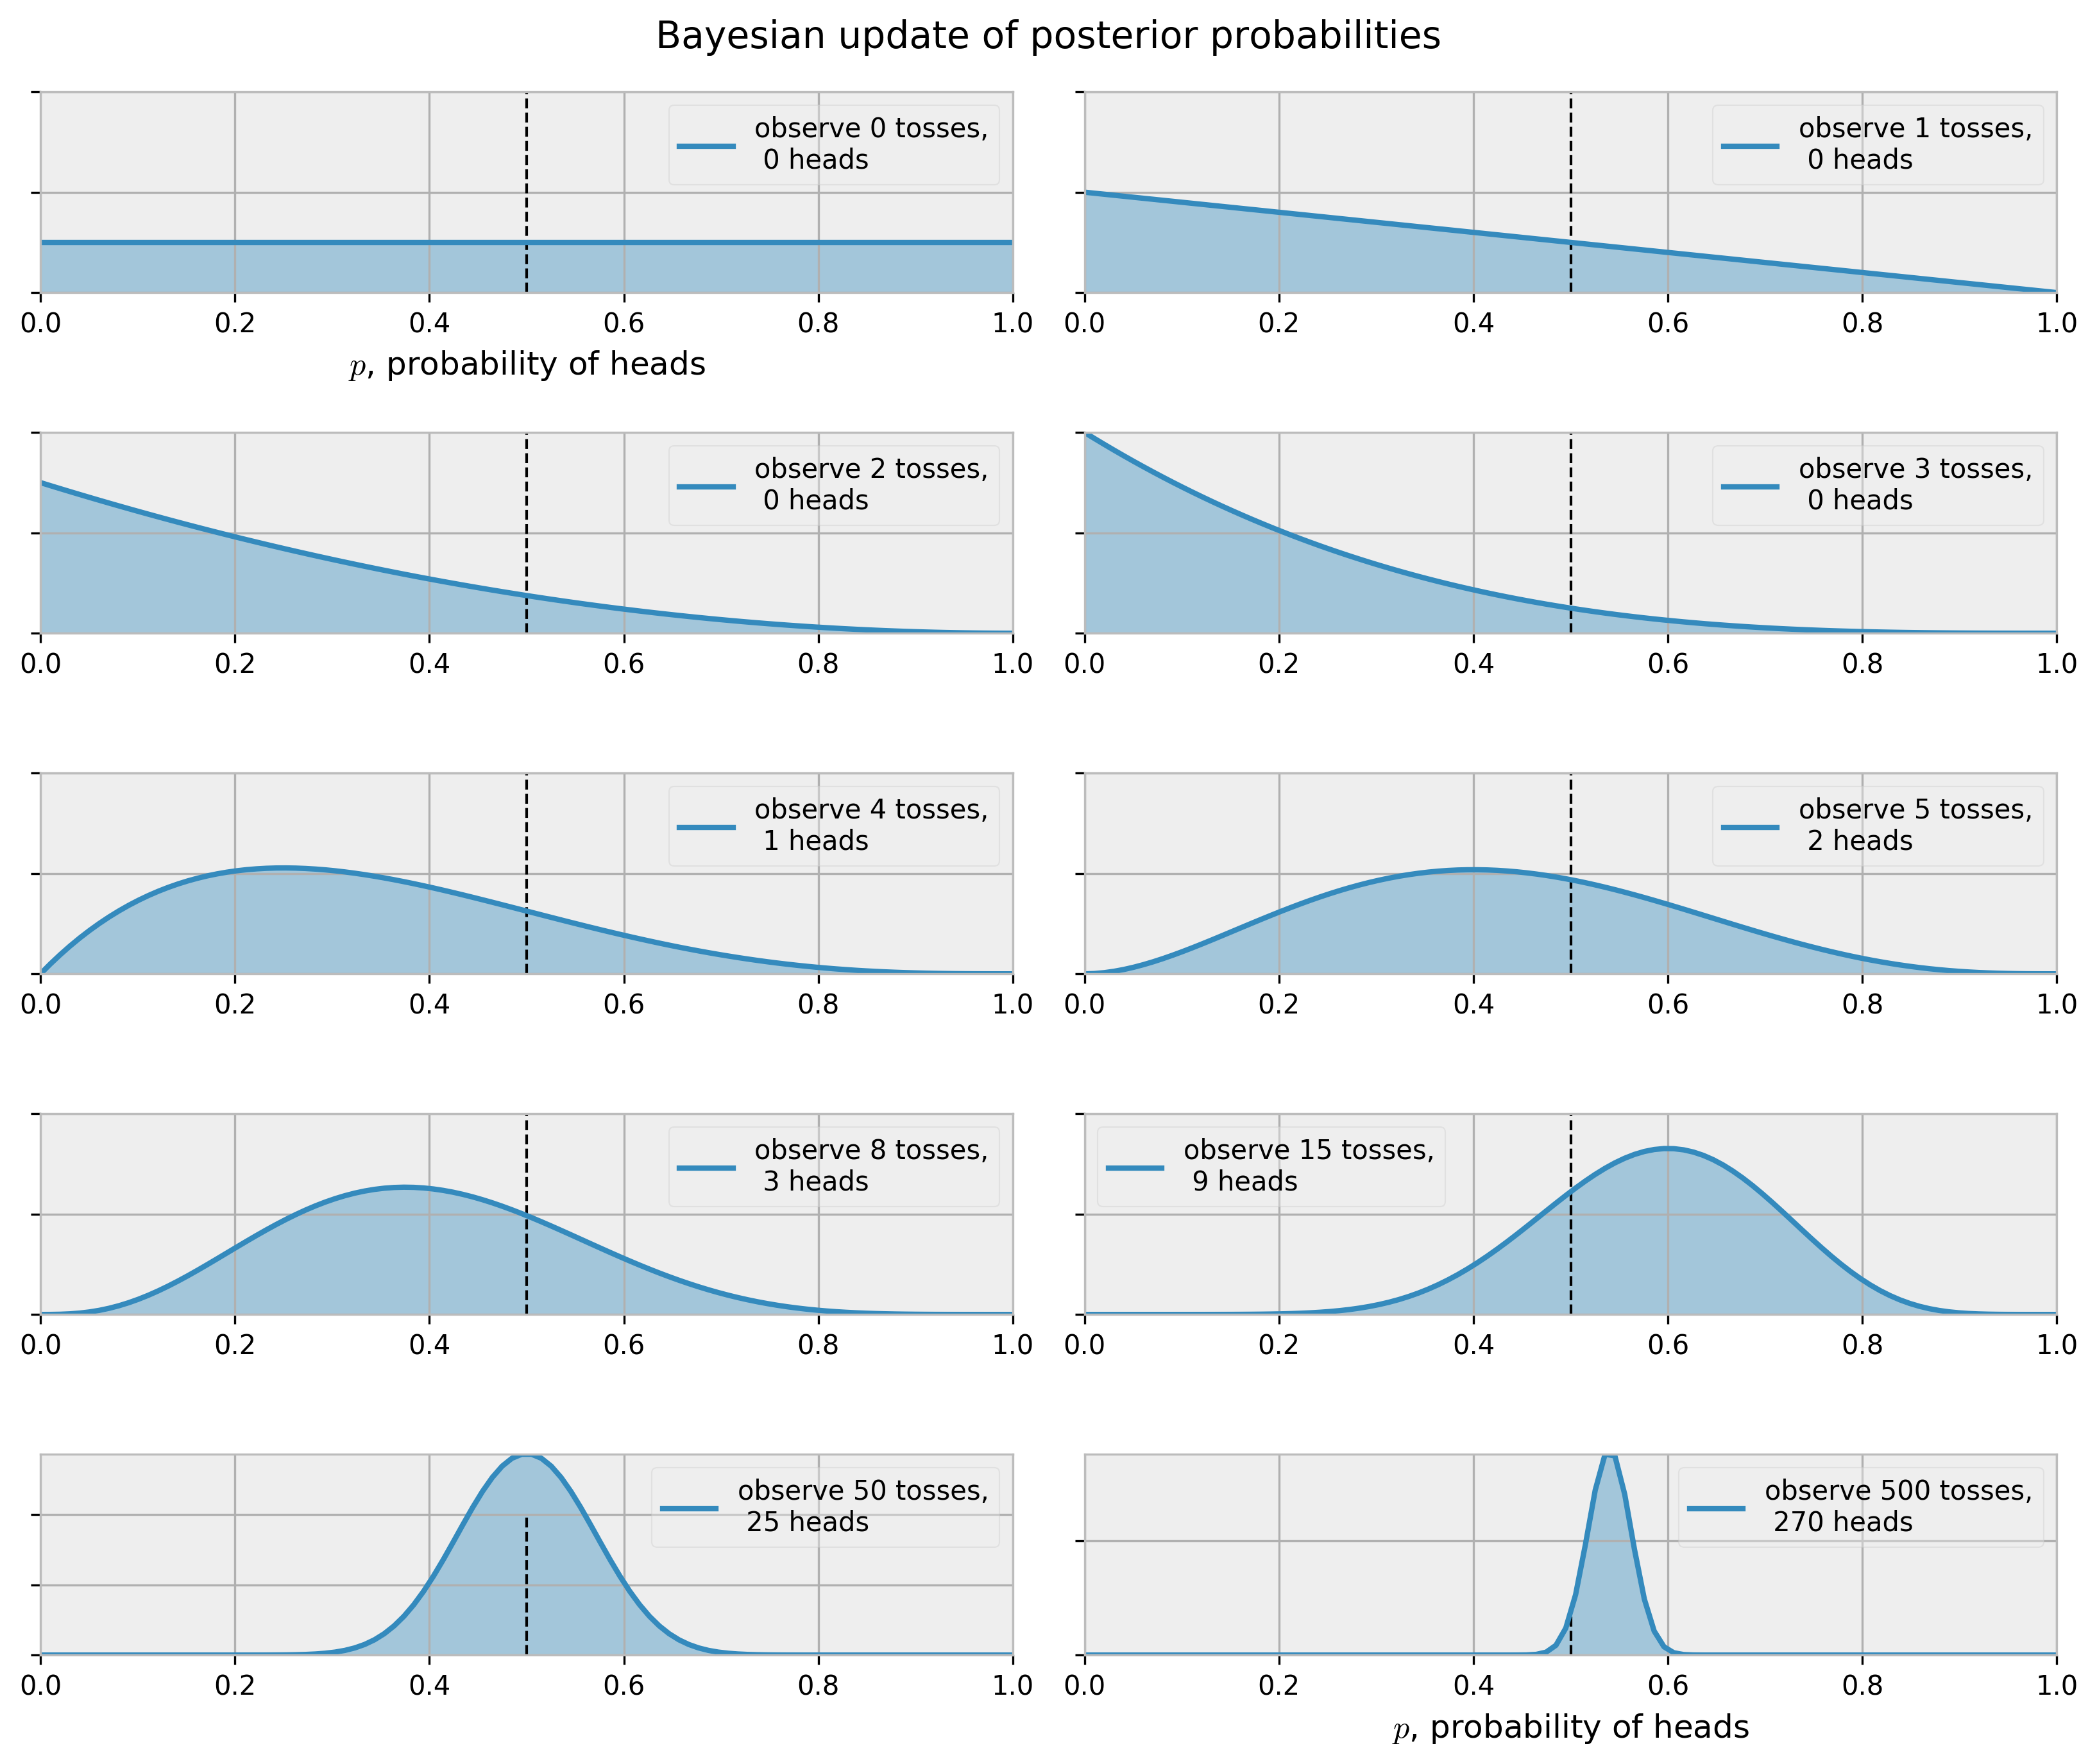

In [11]:
% matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0,1,100)

for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)/2, 2, k+1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe {} tosses,\n {} heads".format(N, heads))
    plt.fill_between(x, 0, y, color = "#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)
    
plt.suptitle("Bayesian update of posterior probabilities", y = 1.02, fontsize = 14)
plt.tight_layout()

## Probability Distributions

Let's quickly recall what a probability distribution is: let $Z$ be some random variable. Then associated with $Z$ is a probability distribution function that assigns probabilities to the different outcomes $Z$ can take. Graphically, a probability distribution is a curve where the probability of an outcome is proportional to the height of the curve.

3 classifications:
* $Z$ is **discrete**
* $Z$ is **continuous**
* $Z$ is **mixed**

### Discrete Case

if $Z$ is discrete, then its distribution is called a *probability mass function*, which measures the probability $Z$ takes on the value $k$. denoted $P(Z = k)$

$Z$ is Poisson distributed if:

$$
P(Z = k) = \frac{\lambda^k e^{-\lambda}}{k!}
$$

$\lambda$ is called a parameter of the distribution and it controls the distribution shape.

One useful property of the Poisson distribution is that its expected value is equal to its parameter, i.e.:

$$
E [ Z | \lambda ] = \lambda
$$

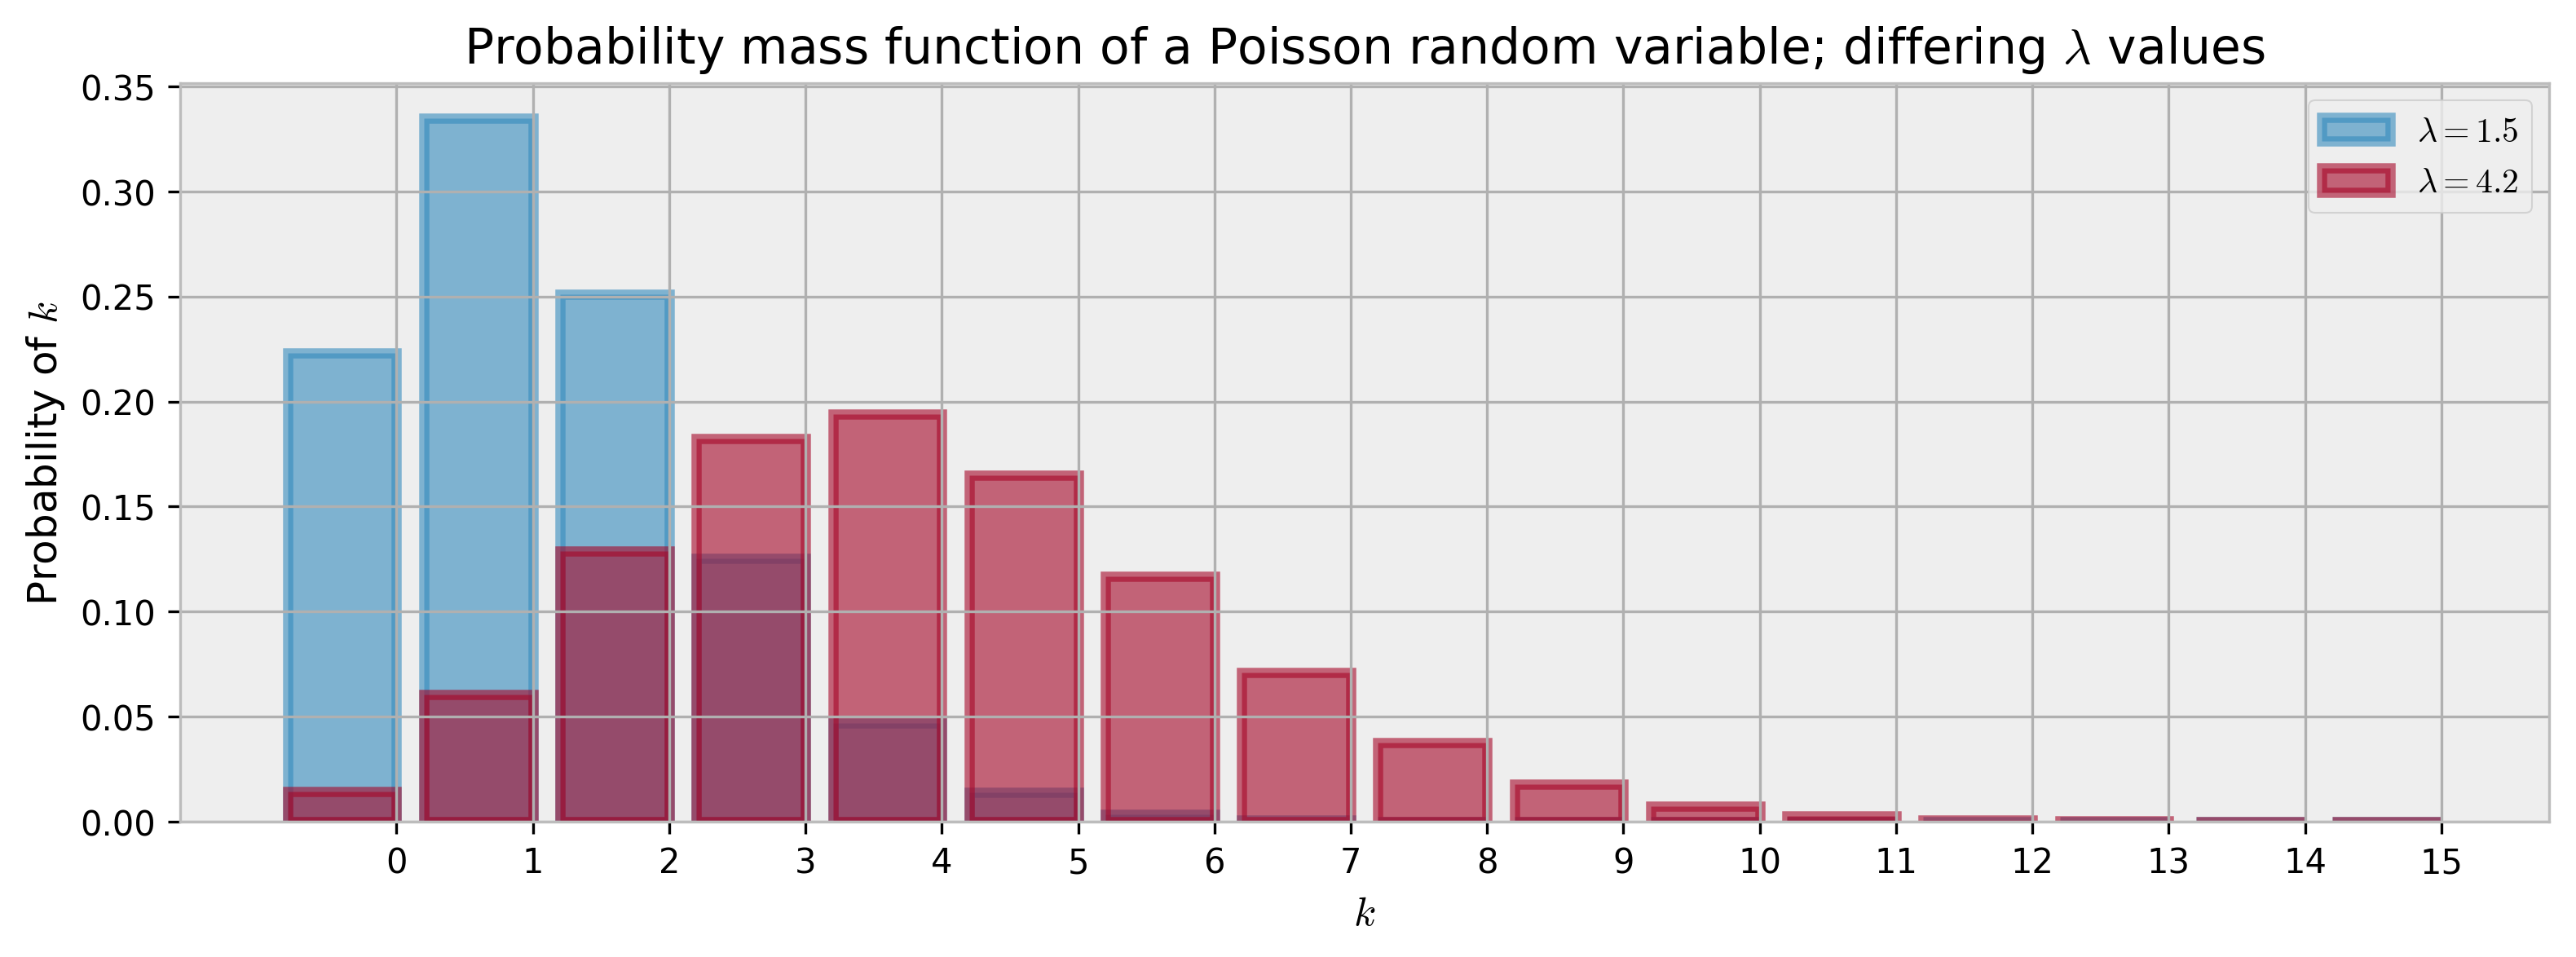

In [3]:
figsize(12.5, 4)

import scipy.stats as stats

dist = stats.poisson
a = np.arange(16)
lambda_ = [1.5, 4.25]
colors = ["#348ABD", "#A60628"]

plt.bar(a, dist.pmf(a, lambda_[0]), color=colors[0], label="$\lambda = %.1f$" % lambda_[0], 
        alpha=0.6, edgecolor=colors[0], lw="3")
plt.bar(a, dist.pmf(a, lambda_[1]), color=colors[1], label="$\lambda = %.1f$" % lambda_[1], 
        alpha=0.6, edgecolor=colors[1], lw="3")
        
plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("Probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing $\lambda$ values")
                                    

### Continuous Case

A continuous random variable has a *probability density function*. The density function and the mass function are very different creatures. 

$$
f_z(z|\lambda) = \lambda e^{-\lambda z}, \;\; z \ge 0
$$

Given a specific $\lambda$, the expected value of an exponential random variable is equal to the inverse of $\lambda$, that is: 

$$
E[Z | \lambda] = \frac{1}{\lambda}
$$

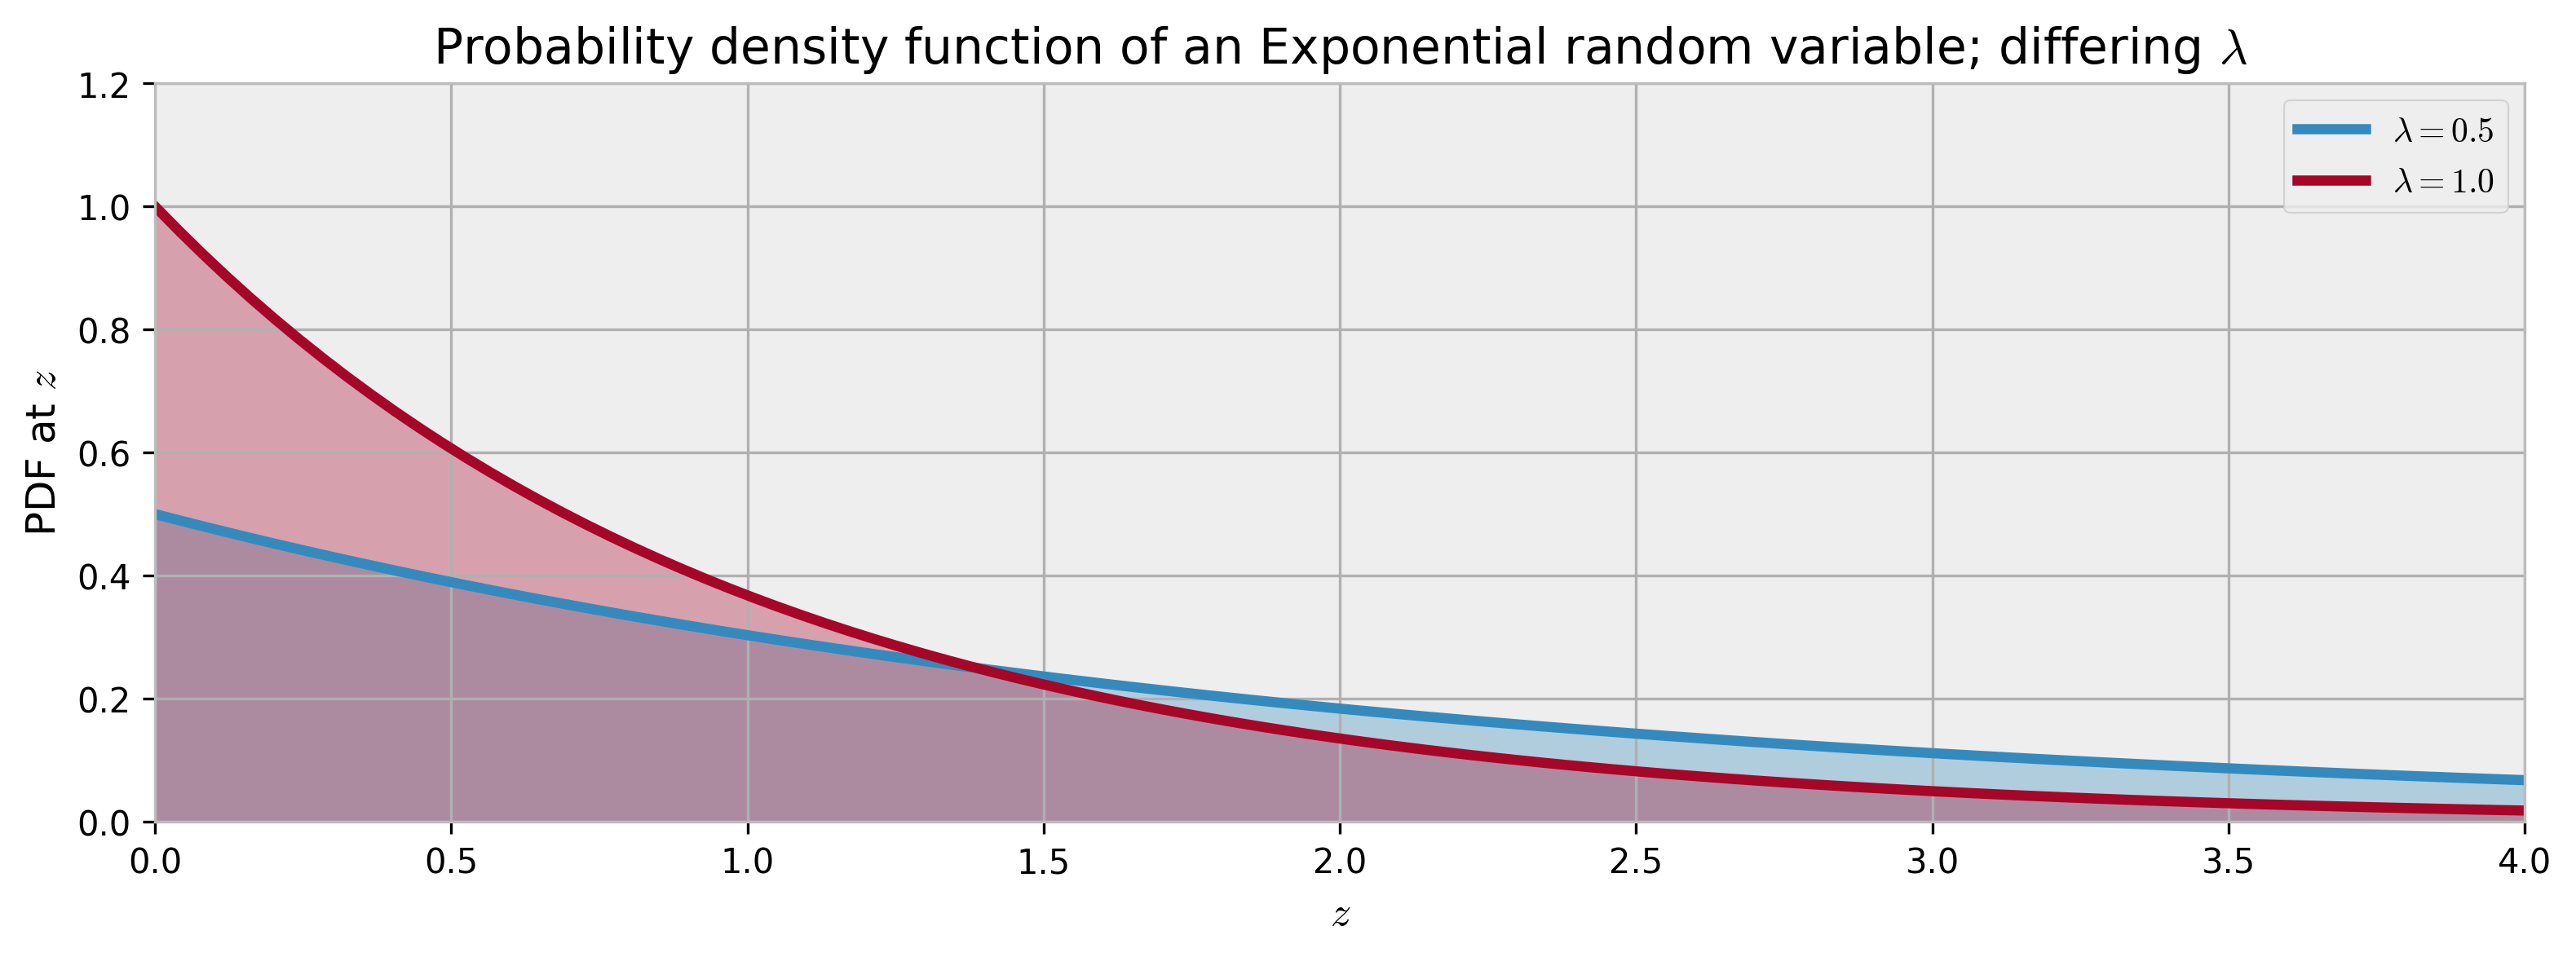

In [4]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colors):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3, color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)
    
plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0, 1.2)
plt.xlim(0, 4)
plt.title("Probability density function of an Exponential random variable; differing $\lambda$")

# Example: Inferring behaviour from text-message data

Let's try a model a more interesting example, one that concerns the rate at which a user sends and receives text messages:

> You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddely. How can you model this? (This is in fact my own text-messate data. judge my popularity as you wish).

(0, 74)

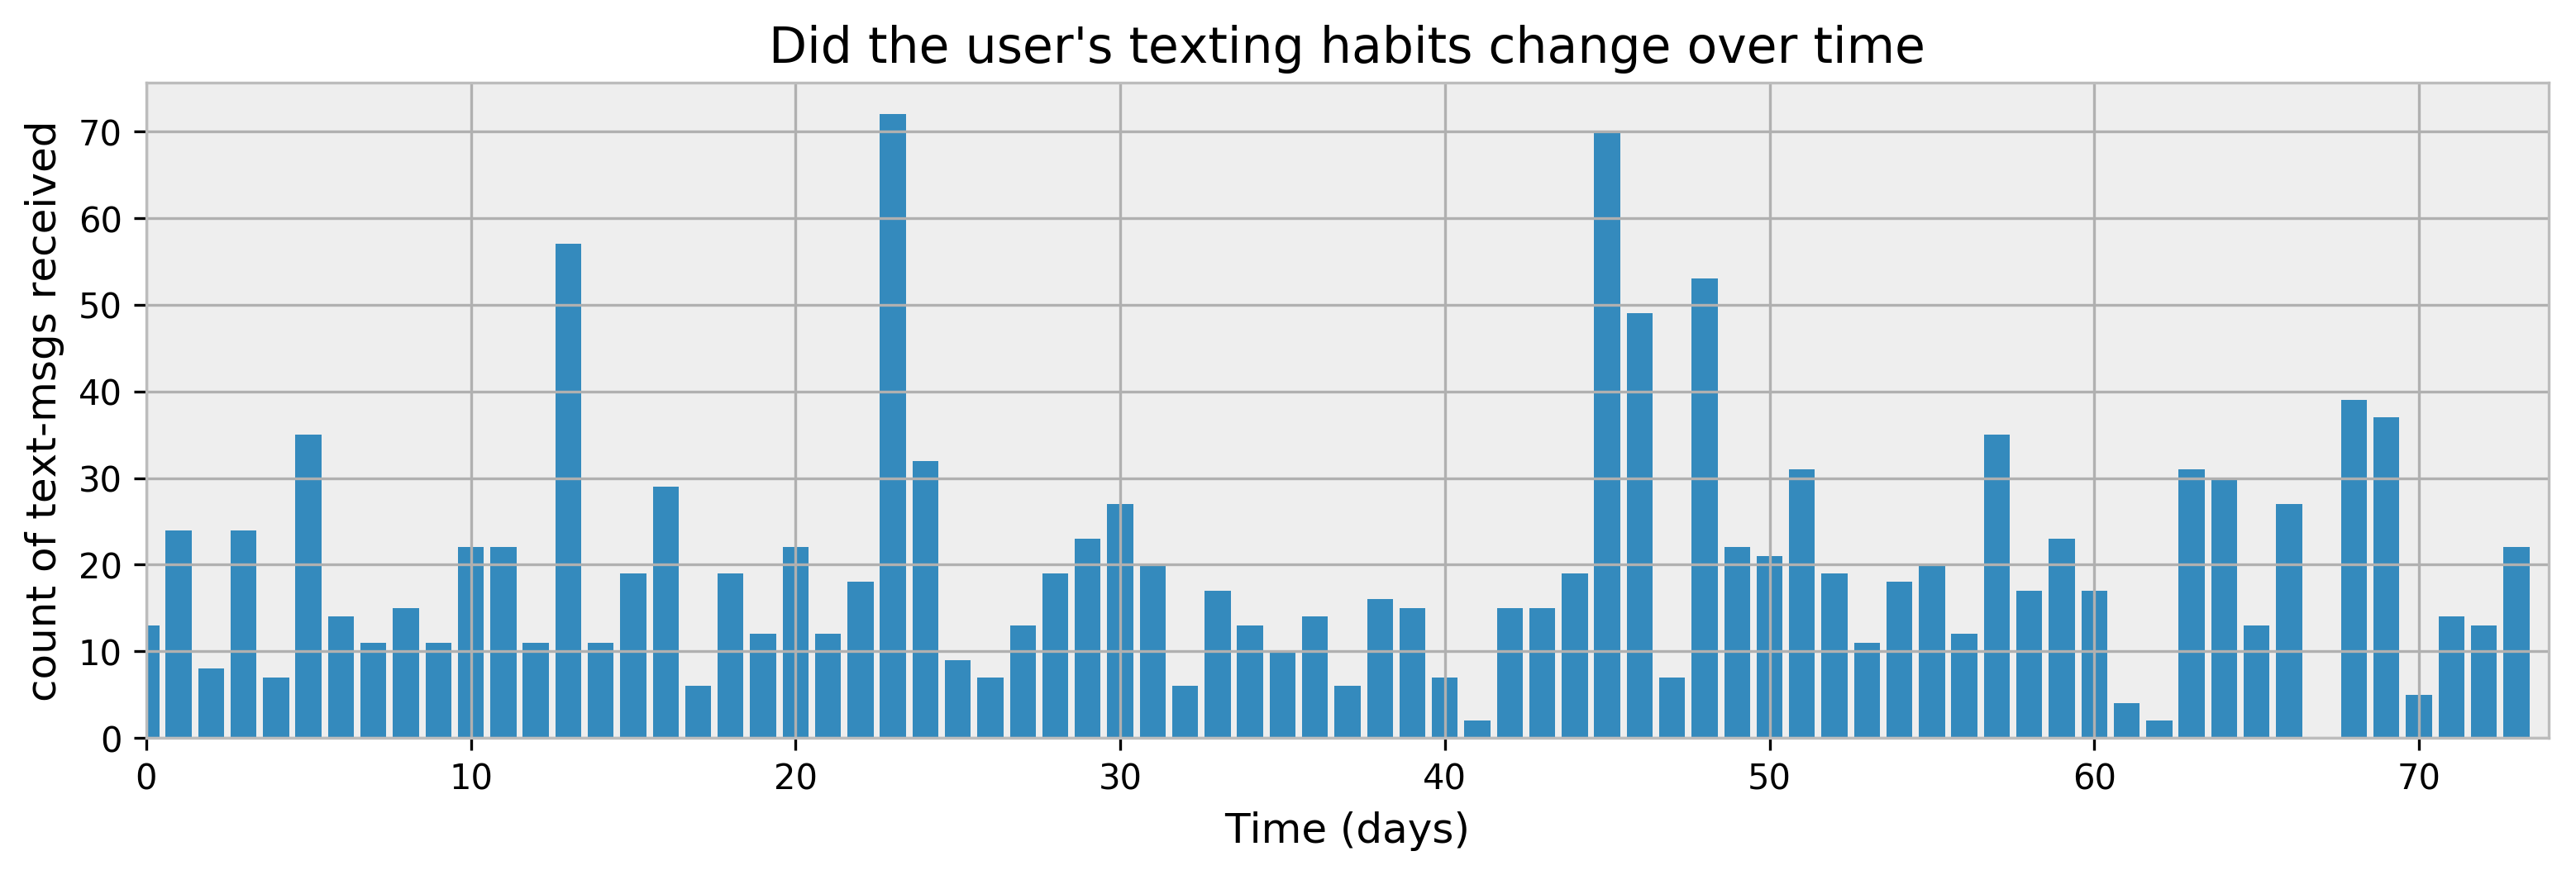

In [5]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time")
plt.xlim(0, n_count_data)

a Poisson random variable is a very appropriate model for this type of count data. Denoting day i's text-message count as $C_i$,

$$ C_i \sim Poisson(\lambda) $$

We are not sure what the value of the $\lambda$ parameter really is. It appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations.

Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of observation period. In the literature, a sudden transition like this would be called a *switch point*.

$$
\lambda = \begin{cases}
    \lambda_1 & \text{if } t \lt \tau \\
    \lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

If, in reality, no sudden change occurred and indeed $lambda_1 = lambda_2$, then the $\lambda$ posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$. To use Bayesian inference, we need to assign prior probabilities to the different values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$ Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. 

$$
\begin{align}
    & \lambda_1 \sim \text{Exp }(\alpha) \\
    & \lambda_2 \sim \text{Exp }(\alpha)
\end{align}
$$

$\alpha$ is called *hyper-parameter*

In [12]:
import pymc3 as pm

with pm.Model() as model:
    alpha = 1.0 / count_data.mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    
with model:
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [14]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune = 5000, step = step)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4220.38it/s]


In [8]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

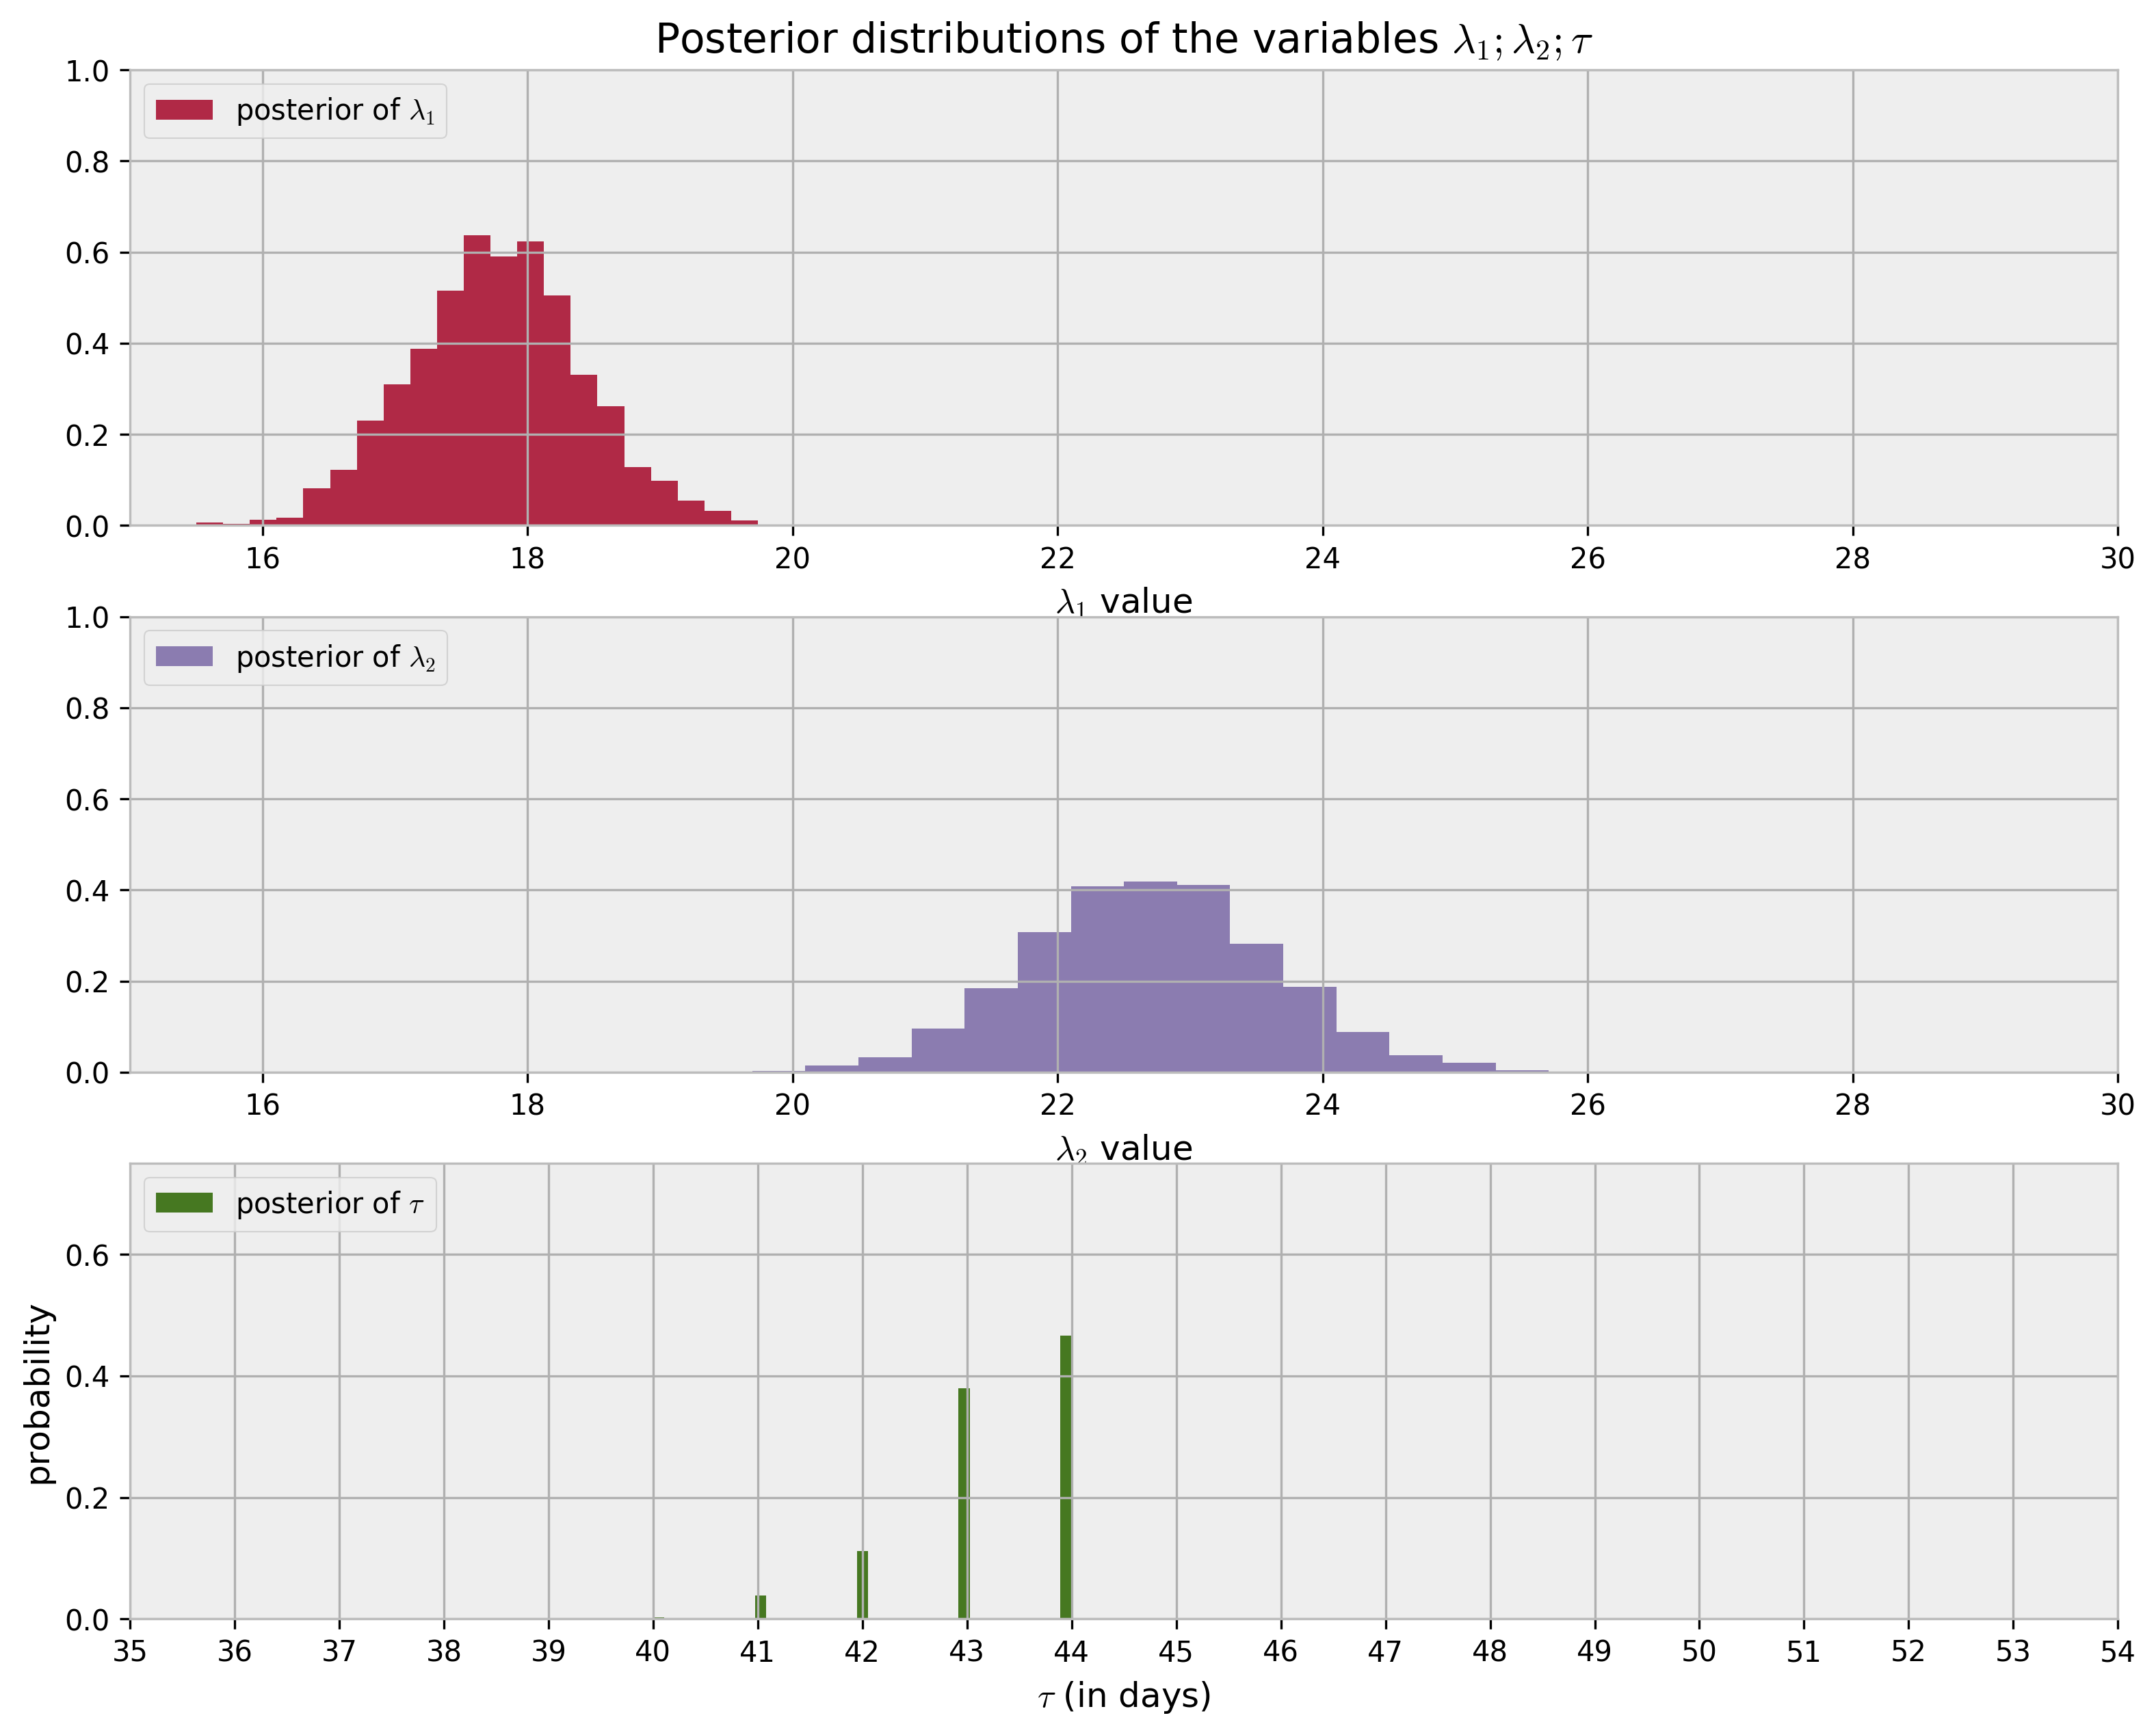

In [9]:
figsize(12.5, 10)

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype="stepfilled", bins=30, alpha=0.85, 
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1; \lambda_2; \tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)

plt.hist(lambda_2_samples, histtype="stepfilled", bins=30, alpha=0.85, 
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins = n_count_data, alpha = 1, label=r"posterior of $\tau$",
        color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")

